In [1]:
#from neural_networks.LSTM_Long_Short_Term_Mermory.LSTM_torch_class import LSTM_torch
from neural_networks.nn_helper_functions import init_weights_LSTM as init_weights
import torch
import torch.nn as nn
from torch.optim import Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.tensorboard import SummaryWriter
#tensorboard --logdir 'runs\LSTM_pytorch_custom' --host localhost --port 8888
from IPython.display import clear_output
clear_output()

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model

# Read data, remove trend

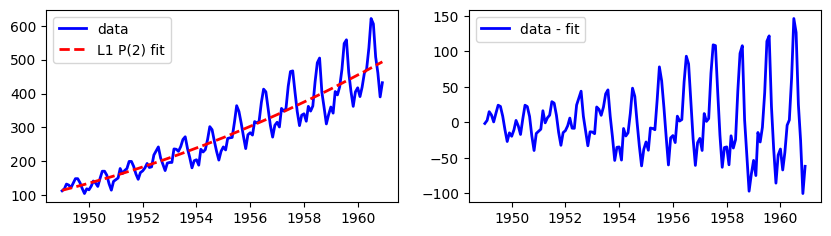

In [3]:
df = pd.read_csv(os.path.join('data_processing','media','airline-passengers.csv'), index_col=0, parse_dates=True)

timeseriesOG  = torch.tensor(df["Passengers"].values, dtype = torch.float)

phi         = torch.ones(len(timeseriesOG), 3)
phi[:,1]    = torch.arange(len(timeseriesOG))
phi[:,2]    = torch.arange(len(timeseriesOG))**2

regr3 = linear_model.Lasso(alpha=0.05, fit_intercept=False).fit(phi, timeseriesOG)  
fit = phi @ regr3.coef_

fig, ax = plt.subplots(1,2, figsize=(10,2.5))
ax = ax.flatten()

ax[0].plot(df.index, timeseriesOG, color='blue', linestyle='-', linewidth=2, label='data')
ax[0].plot(df.index, fit.numpy(), color='red', linestyle='--', linewidth=2, label='L1 P(2) fit')
ax[0].legend()

ax[1].plot(df.index, timeseriesOG-fit.numpy(), color='blue', linestyle='-', linewidth=2, label='data - fit')
ax[1].legend()

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
timeseries = timeseriesOG.clone()
timeseries -= fit.numpy() 
timeseries = timeseries[None,...].T
timeseries = torch.tensor(scaler.fit_transform(timeseries).T[0]).to(torch.float).to(device)
LEN_DATA = timeseries.size(0);LEN_DATA

144

In [5]:
LOOKBACK = 30
data_slices_train = torch.vstack([timeseries[i:i + LOOKBACK] for i in range(LEN_DATA - LOOKBACK + 1)]).to(device)
NUM_SLICES = data_slices_train.size(0);NUM_SLICES

115

$$
\begin{array}{ll} \\
            i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
            f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
            g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
            o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
            c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
            h_t = o_t \odot \tanh(c_t) \\
        \end{array}
        $$

https://pytorch.org/rl/_modules/torchrl/modules/tensordict_module/rnn.html#LSTMCell.forward

In [6]:
class FakeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, fn1, fn2):
        super(FakeLSTM, self).__init__()

        self.hidden_size      = hidden_size
        self.init_weights     = fn1
        self.init_states      = fn2
        self.shape_Wi_stack   = (4*hidden_size, input_size )
        self.shape_Wh_stack   = (4*hidden_size, hidden_size)
        self.shape_b_stack    = (4*hidden_size, 1          )

        self.Wi_stack   = nn.Parameter(self.init_weights(self.shape_Wi_stack))
        self.Wh_stack   = nn.Parameter(self.init_weights(self.shape_Wh_stack))
        self.bi_stack   = nn.Parameter(self.init_weights(self.shape_b_stack ))
        self.bh_stack   = nn.Parameter(self.init_weights(self.shape_b_stack ))

        self.sigmoid    = nn.Sigmoid()
        self.tanh       = nn.Tanh()

        self.lin = nn.Linear(hidden_size, input_size)
    
    def forward(self, x_inp, hs_prev = None, h_states = None, cs_prev = None):
        # data [n_features, sequence length]
        iters = x_inp.size(1)
        hs = self.hidden_size
        if hs_prev is None or h_states is None or cs_prev is None:

            hs_hist = self.init_states((hs, iters + 1   ))#.requires_grad_(True)
            cs_hist = self.init_states((hs, iters + 1   ))#.requires_grad_(True)

        for i in range(iters):
            x_t     = x_inp[  :,[i]]    # [n_features , 1]
            hs_prev = hs_hist[:,[i]]    # [hidden_size, 1]
            cs_prev = cs_hist[:,[i]]    # [hidden_size, 1]

            #[4*hidden, n_features]x[n_features , 1] + [4*hidden, 1] + [4*hidden, hidden]x[hidden,1] + [4*hidden, 1]
            gates = self.Wi_stack @ x_t + self.bi_stack + self.Wh_stack @ hs_prev + self.bh_stack
            
            gate_input, gate_forget, gate_cell, gate_output = gates.chunk(4)

            gate_input     = self.sigmoid(  gate_input )
            gate_forget    = self.sigmoid(  gate_forget)
            gate_cell      = self.tanh(     gate_cell  )
            gate_output    = self.sigmoid(  gate_output)

            state_cell      = gate_forget * cs_prev + gate_input * gate_cell
            state_hidden    = gate_output * self.tanh(gate_cell)
            hs_hist[:,[i+1]] = state_hidden    # store
            cs_hist[:,[i+1]] = state_cell

        output = self.lin(state_hidden.view(-1))

        return output, state_cell, state_hidden

In [7]:
HIDDEN_SIZE = 100
def fn1(shape: tuple):
    return init_weights(shape,HIDDEN_SIZE).to(device)

def fn2(shape: tuple):
    #return init_weights(shape,HIDDEN_SIZE).to(device)
    return torch.zeros(shape).to(device)

net = FakeLSTM(1,HIDDEN_SIZE, fn1, fn2).to(device)
criterion = nn.MSELoss()
optimizer = Adam(net.parameters(), lr = 1e-4)#, weight_decay=1e-5)

# Train model
learn to predict 1 step ahead
test by predicting N_FORWARD steps into future

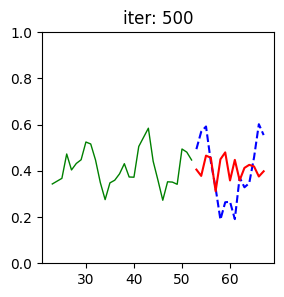

iter: 500 loss: 4.5957 test_loss:  0.022712521255016327 start:  23


KeyboardInterrupt: 

In [8]:
NUM_EPOCHS = 3500

now = datetime.datetime.now()
s2 = now.strftime("%H_%M_%S")
writer = SummaryWriter(os.path.join('runs', 'LSTM_pytorch_custom', s2))
step = 0

N_FORWARD = 15

for i in range(NUM_EPOCHS):
    loss2 = 0
    #js = torch.randperm(data_slices_train.size(0) - 1)
    js = torch.arange(data_slices_train.size(0) - 1)  
    for j in js:
        output = net(data_slices_train[j].unsqueeze(0))[0]
        y = data_slices_train[j+1,-1:]
        loss   = criterion(output, y)
        loss2 += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # test prediction of N steps forward
    if i % 100 == 0:
            with torch.no_grad():
                clear_output()
                plt.figure(figsize=(3,3))
                plt.clf()

                random_start = torch.randint(high= NUM_SLICES - N_FORWARD - 5, size = (1,)).item()

                idx_base = range(random_start, random_start + LOOKBACK)
                
                data_buffer  = timeseries[idx_base].unsqueeze(0)
                data_buffer_old = data_buffer.clone()
                
                idx_pred = range(random_start + LOOKBACK, random_start + LOOKBACK + N_FORWARD)
                y_true = timeseries[idx_pred]

                plt.plot(idx_base, data_buffer.view(-1).cpu().numpy()   , c='green' , lw = 1)
                plt.plot(idx_pred, y_true.cpu().numpy()                 , c='blue'  , ls = '--')

                hs_prev = fn2((HIDDEN_SIZE, 1))
                cs_prev = fn2((HIDDEN_SIZE, 1))
                y_pred  = torch.zeros_like(y_true)

                for k in range(N_FORWARD): 
                    output, hs_prev, cs_prev = net.forward(data_buffer, hs_prev, cs_prev)
                    y_pred[k] = output[0]   # save prediction
                    # shift buffer values to left by 1, add predict in the end
                    data_buffer.view(-1)[:-1] = data_buffer_old.view(-1)[1:]
                    data_buffer.view(-1)[-1] = output[0]
                    data_buffer_old = data_buffer.clone()
                    
                loss_test = criterion(y_true,y_pred)
                
                plt.plot(idx_pred, y_pred.cpu().numpy(), c='red')
                plt.ylim(0, 1)
                plt.title(f'iter: {i}')
                plt.show()

                print('iter:',i, f'loss: {loss2:0.4f}', 'test_loss: ', loss_test.item(), 'start: ', random_start)

        
    if i % 501 == 0 and i > 1:
         torch.save(net.state_dict(), os.path.join('neural_networks','save_states','LSTM',f'LSTM_pytorch_custom_{HIDDEN_SIZE}.pht'))
    writer.add_scalar('Training Loss', loss2, global_step=step)
    step += 1

In [28]:
torch.arange(6).reshape(6,1).chunk(2)

(tensor([[0],
         [1],
         [2]]),
 tensor([[3],
         [4],
         [5]]))

In [ ]:
torch.tensor([1,2,3]).to(torch.float).requires_grad_(True)


tensor([1., 2., 3.], requires_grad=True)